# Math 86 Final Project

## Comparing AMM's

### Alex Craig, Wanxin Hu, Ganqi Li, Fangzhou Yu

## Part 1. Simple AMM

The simple AMM follows the model $xy = k$, where $k$ remains constant assuming no liquidity is provided or removed. Let's instantiate a simple AMM and see how it behaves.

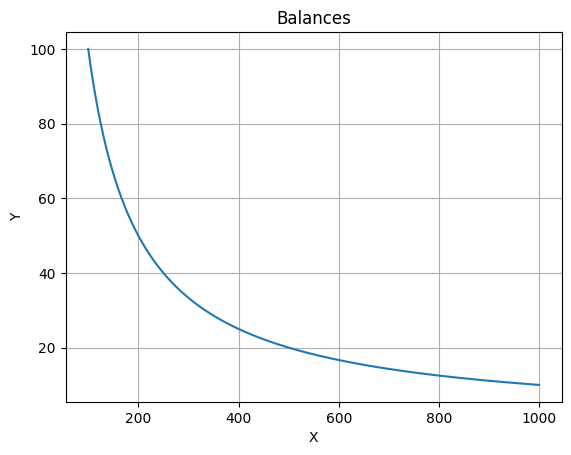

In [54]:
from simulations.simple import Simple
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

simple = Simple(100, 100)

balances = [[simple.x, simple.y]]

delta = 1
x_max = 1000

while simple.x < x_max:
    simple.swap_x_for_y(delta)
    balances.append([simple.x, simple.y])
    
# Plot the balances
balances = np.array(balances)
plt.plot(balances[:, 0], balances[:, 1])
plt.title('Balances')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

In [55]:
def calculate_impermanent_loss(new_price_ratio, initial_price_ratio = 1):
    price_ratio_change = new_price_ratio / initial_price_ratio
    il = 2 * (price_ratio_change ** 0.5) / (1 + price_ratio_change) - 1
    return il * 100  # Return IL as a percentage

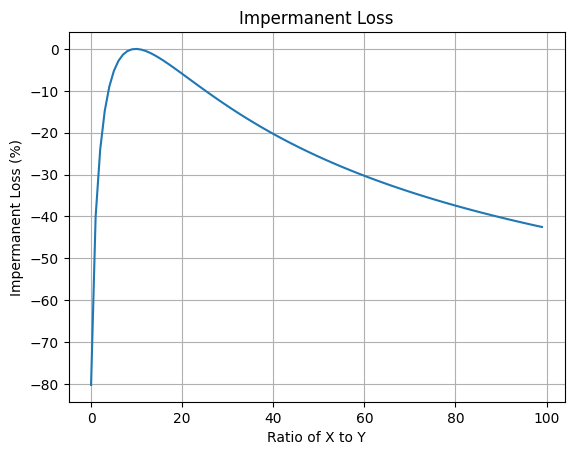

In [56]:
# Sample ratios
ratios = np.linspace(0.01, 10, 100)
# Calculate the impermanent loss
impermanent_losses = [calculate_impermanent_loss(r) for r in ratios]

# Plot the impermanent loss
plt.plot(impermanent_losses)
plt.title('Impermanent Loss')
plt.xlabel('Ratio of X to Y')
plt.ylabel('Impermanent Loss (%)')
plt.grid()
plt.show()

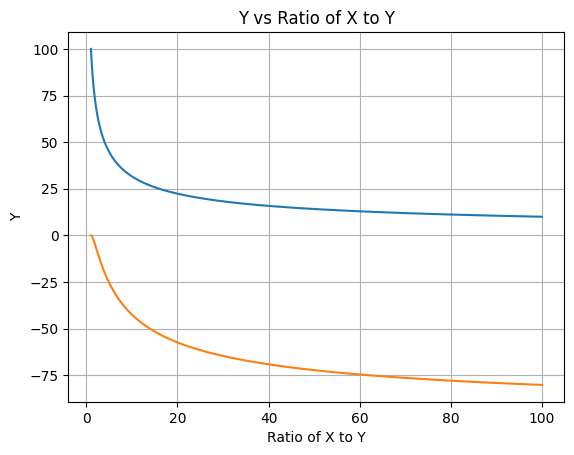

In [57]:
# Plotting impermanent loss vs price ratio
ratios_from_balances = balances[:, 0] / balances[:, 1]
impermanent_losses_from_balances = [calculate_impermanent_loss(r) for r in ratios_from_balances]

# Plot Y vs ratio of X to Y
plt.plot(ratios_from_balances, balances[:, 1])
plt.plot(ratios_from_balances, impermanent_losses_from_balances)
plt.title('Y vs Ratio of X to Y')
plt.xlabel('Ratio of X to Y')
plt.ylabel('Y')
plt.grid()
plt.show()